In [59]:
# core scientific libraries
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# secondary libraries
import netCDF4 as nc
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, CoordPair, vertcross, g_uvmet, interpline, destagger,
                interp2dxy, ll_to_xy, xy, ALL_TIMES, vinterp, uvmet)
import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as constants
from math import fabs, log, cos, sin, tan, pi

import pytz

from xarray.backends.netCDF4_ import NetCDF4DataStore

import copy 
import time
from datetime import datetime

In [60]:
# Set filepath
# datdir = '../input_data/'
# filename = 'wrfout_d03_2017-05-25_00:00:00'

datdir = '../input_data/'
filename = 'wrfout_d03_2017-05-25_00:00:00'

# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/data/'


# open wrf Dataset object
filepath = datdir + filename
print('Opened File:', filepath, '\n')

# Open NetCDF Dataset object
f = nc.Dataset(filepath,'r')

# List variable names
#print("Variables:")
#print(f.variables.keys(),'\n')

# Show variavles and all details
#print(f.variables.items(),'\n')

# Show dimension names and sizes
#print("Dimensions:")
#print(f.dimensions.items(),'\n')

# Print all file metadata
#print(f)   # or run 'ncdump -h <filename>' in terminal

Opened File: ../input_data/wrfout_d03_2017-05-25_00:00:00 



In [61]:
# specify desired variables to grad from the wrf out file and their units
des_vars = ["T2", "slp", "uvmet10", "uvmet10_wspd_wdir", "rh2"]
var_units = [None, "hpa", "m s-1", "m s-1", None]

# save the number of times in the file
n_times = len(f['Times'])

# make empty list to append interpolated dataarrays too
data = []

# start timer
t0 = time.time()

# loop through variables
for i in range(len(des_vars)): 
    
    # make empty list to append getvar single index times too
    tmp_list = []
    tmp_list2 = []
    
    # loop through times
    for indx in range(n_times):
    
        # grab var with units at time index
        if (var_units[i] != None):
            tmp_indx = getvar(f, des_vars[i], units = var_units[i], timeidx = indx)
        else:
            tmp_indx = getvar(f, des_vars[i], timeidx = indx)
        
        if (des_vars[i] == "uvmet10" or des_vars[i] == "uvmet10_wspd_wdir"): # some get vars output two variables
            tmp_1, tmp_2 = tmp_indx

            if (des_vars[i] == "uvmet10"):
                tmp_1 = tmp_1.rename('u').drop("u_v")
                tmp_2 = tmp_2.rename('v').drop("u_v")
            else:
                tmp_1 = tmp_1.rename('wspd').drop("wspd_wdir")
                tmp_2 = tmp_2.rename('wdir').drop("wspd_wdir")

            tmp_list.append(tmp_1)
            tmp_list2.append(tmp_2)

        else:
            
            tmp_list.append(tmp_indx)

    
    if (des_vars[i] == "uvmet10" or des_vars[i] == "uvmet10_wspd_wdir"): # some get vars output two variables
    
        # combine all timesteps together
        tmp = xr.concat(tmp_list, dim = 'time')
        tmp2 = xr.concat(tmp_list2, dim = 'time')

    
        # fix projection labeling for saving as a netcdf https://github.com/NCAR/wrf-python/issues/91
        del tmp.attrs['coordinates']
        del tmp2.attrs['coordinates']

        tmp.attrs['projection'] = str(tmp.attrs['projection'])
        tmp2.attrs['projection'] = str(tmp2.attrs['projection'])

        # append to list for all variables
        data.append(tmp)
        data.append(tmp2)
    
    
    else:
        
        # combine all timesteps together
        tmp = xr.concat(tmp_list, dim = 'time')

        # fix projection labeling for saving as a netcdf https://github.com/NCAR/wrf-python/issues/91
        del tmp.attrs['coordinates']

        tmp.attrs['projection'] = str(tmp.attrs['projection'])

        # append to list for all variables
        data.append(tmp)
    
    
# merge into one dataset    
data = xr.merge(data)

# add terrian height to dataset after correcting the projection labeling
terr = getvar(f, "ter", units = 'm', timeidx = 0)

del terr.attrs['coordinates']

terr.attrs['projection'] = str(terr.attrs['projection'])
 
data['terr']  = terr  
    
# pull lat and lon vallues and replace current corrdinates
lats = data.XLAT.values[:,0]
lons = data.XLONG.values[0,:]

data['south_north'] = lats
data['west_east'] = lons

# remane dimensions with ugly names
data = data.rename({'south_north':'lat', 'west_east':'lon', 'XTIME':'time', 'XLAT':'lat_grid', 
                    'XLONG':'lon_grid'})

# fix the time coordinates
data['time'] = data['Time']
data = data.drop("Time")

# save time variable
timez = data.time.values

# save times as datetimes
dates = []
dates_list = []

# store dates as a datetine and convert it to PDT timezone
for i in range(len(timez)):
    dates_obj = datetime.strptime(str(timez[i]), '%Y-%m-%dT%H:%M:%S.000000000')
    dates_obj_zone = dates_obj.replace(tzinfo =  pytz.timezone('UTC'))
    dates_obj_PDT = dates_obj_zone.astimezone(pytz.timezone('US/Pacific'))
    datetime64_PDT = np.datetime64(str(dates_obj_PDT)[:16]).astype(datetime)
    dates.append(datetime64_PDT)

    dates_list.append(datetime64_PDT)

data["time"] = dates_list

# end timer
t1 = time.time()
total = t1-t0
print('----------------------')
print("time:", total)

----------------------
time: 9.663878202438354


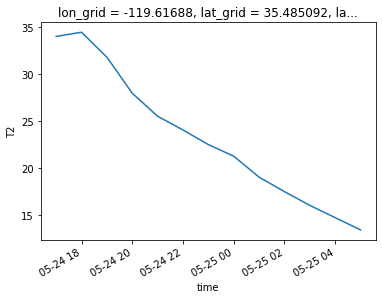

In [74]:
data['T2'].sel(lat = 35.468475, lon = -119.63031).plot()

In [72]:
data.lon

<xarray.DataArray 'lon' (lon: 156)>
array([-121.78293 , -121.7612  , -121.73947 , -121.71773 , -121.695984,
       -121.674255, -121.65251 , -121.63077 , -121.60904 , -121.58731 ,
       -121.56555 , -121.54382 , -121.522095, -121.500336, -121.47861 ,
       -121.45686 , -121.43512 , -121.41339 , -121.39165 , -121.3699  ,
       -121.348175, -121.326416, -121.30469 , -121.28294 , -121.2612  ,
       -121.23947 , -121.21771 , -121.195984, -121.174225, -121.1525  ,
       -121.13075 , -121.10901 , -121.087265, -121.06552 , -121.04378 ,
       -121.02203 , -121.000305, -120.978546, -120.95682 , -120.93506 ,
       -120.91333 , -120.89157 , -120.86984 , -120.84808 , -120.82634 ,
       -120.804596, -120.78285 , -120.76111 , -120.739365, -120.71762 ,
       -120.69588 , -120.67413 , -120.652374, -120.630646, -120.60889 ,
       -120.58716 , -120.5654  , -120.543655, -120.52191 , -120.50017 ,
       -120.478424, -120.456665, -120.43494 , -120.41318 , -120.39143 ,
       -120.36969 , -120.34793 , -120.3262  , -120.30444 , -120.2827  ,
       -120.260956, -120.23921 , -120.21747 , -120.19571 , -120.17398 ,
       -120.15222 , -120.13048 , -120.108734, -120.086975, -120.06525 ,
       -120.04349 , -120.02174 , -120.      , -119.97824 , -119.95651 ,
       -119.93475 , -119.91301 , -119.891266, -119.86951 , -119.84778 ,
       -119.82602 , -119.804276, -119.78253 , -119.76077 , -119.739044,
       -119.717285, -119.69554 , -119.6738  , -119.652054, -119.63031 ,
       -119.60855 , -119.58682 , -119.56506 , -119.54332 , -119.521576,
       -119.49982 , -119.47809 , -119.45633 , -119.4346  , -119.41284 ,
       -119.3911  , -119.369354, -119.34761 , -119.32587 , -119.30411 ,
       -119.28238 , -119.26062 , -119.23889 , -119.21713 , -119.195404,
       -119.173645, -119.15192 , -119.13016 , -119.10841 , -119.08667 ,
       -119.064926, -119.04318 , -119.02144 , -118.999695, -118.97797 ,
       -118.95621 , -118.93448 , -118.91272 , -118.89099 , -118.86923 ,
       -118.8475  , -118.82576 , -118.804016, -118.78227 , -118.76053 ,
       -118.7388  , -118.71704 , -118.69531 , -118.67357 , -118.651825,
       -118.6301  , -118.60834 , -118.58661 , -118.564865, -118.54312 ,
       -118.52139 , -118.49965 , -118.477905, -118.45618 , -118.43443 ,
       -118.41269 ], dtype=float32)
Coordinates:
  * lon      (lon) float32 -121.78293 -121.7612 ... -118.43443 -118.41269

In [62]:
# convert temp from K to c
data['T2'] = data['T2'] - 273.15

In [63]:
filename_out = filename + "_surf"

data.to_netcdf(path = dat_outdir + filename_out)

print('Saved Files As: \n', dat_outdir + filename_out)

Saved Files As: 
 /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/post_processing/outputs/data/wrfout_d03_2017-05-25_00:00:00_surf
